In [1]:
import anndata as ad
import torch
import vapor
from vapor.config import VAPORConfig

/home/ubuntu/miniconda3/envs/vapor/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [3]:
# Load data
adata = ad.read_h5ad('../data/drugSeries.h5ad')
print(adata.obs.groupby('cell_line').size().sort_values())

# Count and log normalize
X = adata.X
X = 10_000 * X / X.sum(axis=1)
adata.X = X.log1p().tocsc()

# Filter data
# SEPARABLE: LUNG
# NOT SEPARABLE: OESOPHAGUS, CENTRAL_NERVOUS_SYSTEM, KIDNEY, OVARY (256)
# NOT WORKING: LARGE_INTESTINE, UPPER_AERODIGESTIVE_TRACT, URINARY_TRACT
valid_treatments = ['DMSO_48hr']
valid_treatments += [f'Tram_{i}hr' for i in (3, 6, 12, 24, 48)]  # Maybe hold out 24?
mask = adata.obs['treatment'].isin(valid_treatments)
mask *= adata.obs['cell_line'].isin(['LUNG', 'OESOPHAGUS', 'SKIN', 'CENTRAL_NERVOUS_SYSTEM', 'LARGE_INTESTINE'])
adata = adata[mask]

# Normalize
X = adata.X.toarray()
X_std = X.std(axis=0)
X = (X - X.mean(axis=0)) / np.where(X_std==0, 1, X_std)
adata = ad.AnnData(X, obs=adata.obs, var=adata.var)

# Reduce
red = sklearn.decomposition.PCA(n_components=512, random_state=42)
X_pca = red.fit_transform(adata.X)
adata_orig = adata
adata = ad.AnnData(X_pca, obs=adata.obs)

# Annotate timepoints
timepoint_dict = {k: v for k, v in zip(valid_treatments, (0, 3, 6, 12, 24, 48))}  # Should this be scaled?
adata.obs['Timepoint'] = adata.obs['treatment'].apply(lambda x: timepoint_dict[x])

/tmp/ipykernel_38683/783888200.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('cell_line').size().sort_values())


cell_line
BILIARY_TRACT                 222
PROSTATE                      301
ENDOMETRIUM                   614
STOMACH                       665
OVARY                         750
BREAST                        752
URINARY_TRACT                 936
UPPER_AERODIGESTIVE_TRACT     978
KIDNEY                        999
LARGE_INTESTINE              1156
CENTRAL_NERVOUS_SYSTEM       1214
SKIN                         1276
OESOPHAGUS                   1574
LUNG                         2276
dtype: int64


In [4]:
# Create supervised dataset
dataset = vapor.dataset_from_adata(
    adata,
    root_where=['treatment=DMSO_48hr'],
    terminal_where=['treatment=Tram_48hr'],
    time_label='Timepoint',
    root_n=200, terminal_n=200, seed=42,
    scale=True)

Time Range: (0.000, 1.000)
Data scaled per row.
Root selection: matched=1215, sampled=200, where={'treatment': 'DMSO_48hr'}
Terminal selection: matched=734, sampled=200, where={'treatment': 'Tram_48hr'}


In [5]:
# Config
config = VAPORConfig(
    latent_dim=64, n_dynamics=10, lr=5e-4,
    beta=0.01, eta=1.0, t_max=4, epochs=500,
    batch_size=512, device='cuda')

# Initialize model
model = vapor.initialize_model(adata.n_vars, config=config)

Initializing model:
  Input dim: 512
  Latent dim: 64
  Encoder dims: [2048, 512, 128]
  Decoder dims: [128, 512, 2048]
  N dynamics: 10
0.75


Training on device: cuda
Training for 500 epochs with batch size 512
Data split: train=3568, test=892 (test_size=0.2)

Starting training...
--------------------------------------------------------------------------------
Epoch   1/500 | Time:  1.34s | Recon: 1.8460 | KL: 0.1267 | Traj: 1.8577 | Prior: 0.0745 | Psi: 0.9997
Epoch   2/500 | Time:  0.75s | Recon: 1.6689 | KL: 0.1292 | Traj: 1.8768 | Prior: 0.0631 | Psi: 0.9972
Epoch   3/500 | Time:  0.78s | Recon: 1.5782 | KL: 0.1346 | Traj: 1.9105 | Prior: 0.0591 | Psi: 0.9936
Epoch   4/500 | Time:  0.78s | Recon: 1.5204 | KL: 0.1415 | Traj: 1.9326 | Prior: 0.0592 | Psi: 0.9907
Epoch   5/500 | Time:  0.74s | Recon: 1.4665 | KL: 0.1503 | Traj: 1.9450 | Prior: 0.0685 | Psi: 0.9853
Epoch   6/500 | Time:  0.76s | Recon: 1.4130 | KL: 0.1612 | Traj: 1.9422 | Prior: 0.0615 | Psi: 0.9831
Epoch   7/500 | Time:  0.76s | Recon: 1.3627 | KL: 0.1738 | Traj: 1.9554 | Prior: 0.0613 | Psi: 0.9771
Epoch   8/500 | Time:  0.74s | Recon: 1.3106 | KL: 0.1880 

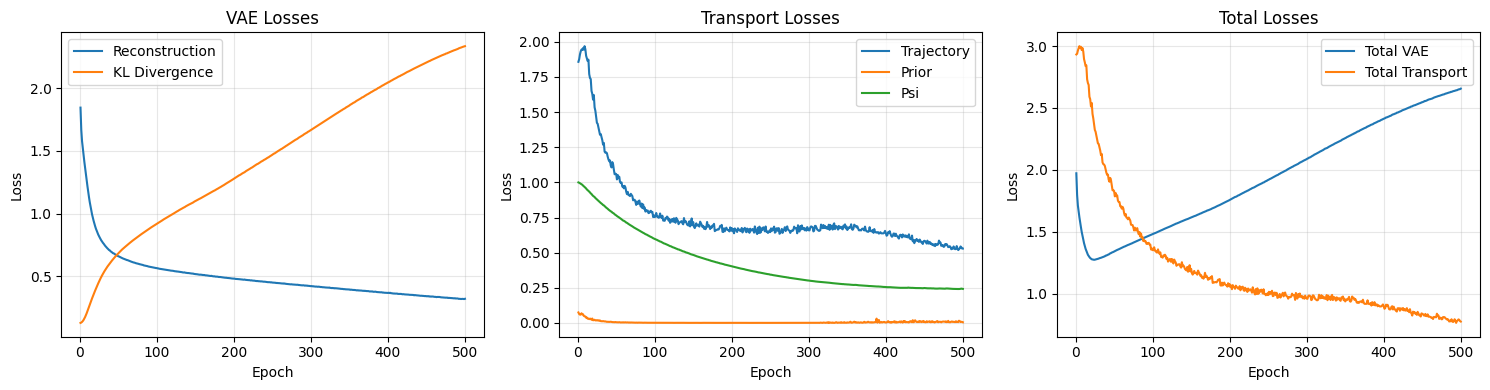

In [6]:
# Load model
# model.load_state_dict(torch.load('./trained_model.h5'))
# trained_model = model

# Train
trained_model = vapor.train_model(model, dataset, config=config)

In [7]:
# Save model
# torch.save(trained_model, './trained_model_large_intestine_logcountnorm.h5')

<Axes: title={'center': 'Timepoint'}, xlabel='UMAP1', ylabel='UMAP2'>

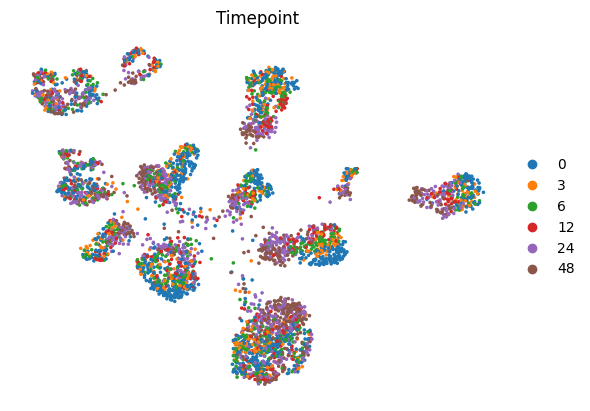

In [8]:
import scanpy as sc
from vapor.inference import extract_latents_and_dynamics
adata_VAPOR = extract_latents_and_dynamics(trained_model, adata, scale=True, device='cpu')

n_neighbors = 20  # 200 results in error
sc.pp.neighbors(adata_VAPOR, n_neighbors=n_neighbors, random_state=42, use_rep='X')
sc.tl.umap(adata_VAPOR)
sc.pl.embedding(adata_VAPOR, basis='umap', color=['Timepoint'], frameon=False, show=False)

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'v_VAPOR_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_VAPOR_umap', embedded velocity vectors (adata.obsm)


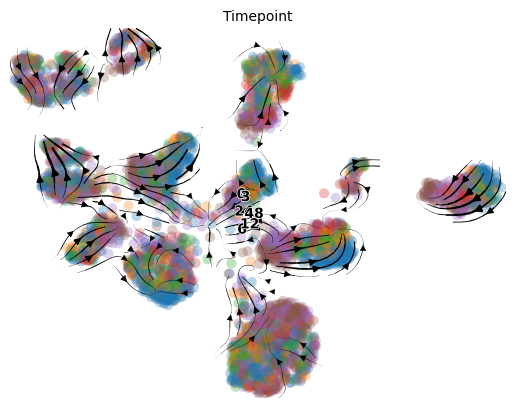

In [9]:
import scvelo as scv
sc.pp.neighbors(adata_VAPOR,use_rep='X_VAPOR', random_state=42, n_neighbors=n_neighbors)
scv.tl.velocity_graph(adata_VAPOR, vkey='v_VAPOR', xkey='vapor')
scv.pl.velocity_embedding_stream(adata_VAPOR, vkey='v_VAPOR', basis='umap',color=['Timepoint'])

In [16]:
# Get UMAP
X = adata_VAPOR.obsm['X_umap']
clust = sklearn.cluster.KMeans(n_clusters=7)
X_clust = clust.fit_predict(X)

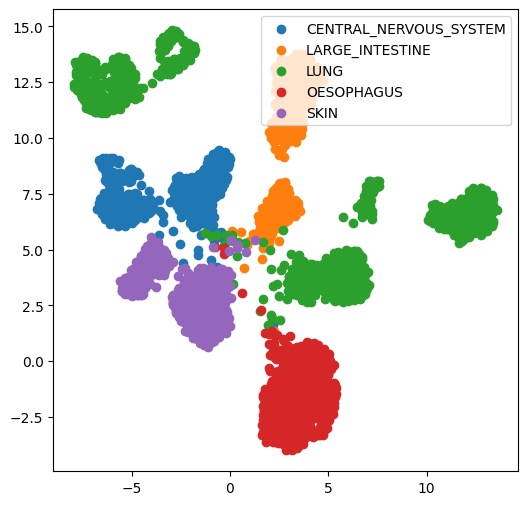

In [17]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sep = adata.obs['cell_line']
for c in np.unique(sep):
    X_filt = X[sep==c]
    ax.scatter(*X_filt.T, label=c)
ax.legend()

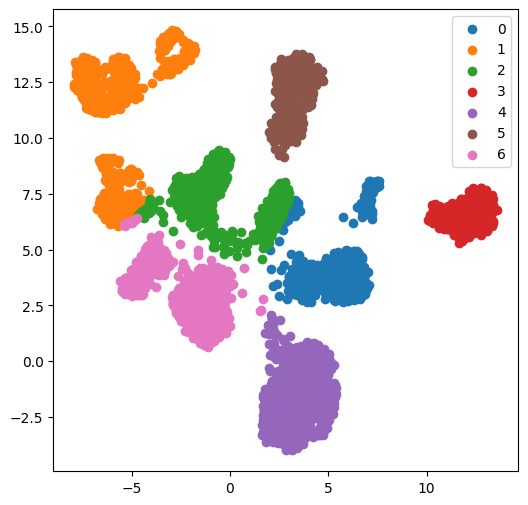

In [18]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sep = X_clust
for c in np.unique(sep):
    X_filt = X[sep==c]
    ax.scatter(*X_filt.T, label=c)
ax.legend()

In [19]:
# Genes by cluster
df = pd.DataFrame(adata_orig.X, columns=adata_orig.var_names)
df['cluster'] = X_clust
cluster_diff = df.groupby('cluster').mean()
cluster_mean_diff = cluster_diff - cluster_diff.mean(axis=0)
max_genes_idx = np.argsort(cluster_mean_diff.abs(), axis=1)[:, ::-1]
max_genes = (
    adata_orig.var['gene_name'].to_numpy()
    [max_genes_idx.flatten()]
    .reshape(max_genes_idx.shape))
max_genes[:, :5]

array([['TGFBI', 'RPS18', 'MT1E', 'LMO3', 'ATP11A'],
       ['CDK6', 'TENM2', 'H3F3A', 'C1S', 'FAM133B'],
       ['COL1A2', 'POSTN', 'SRGN', 'PRRX1', 'COL6A3'],
       ['CLDN6', 'TM4SF18', 'SFTA2', 'ACACA', 'JSRP1'],
       ['FXYD3', 'PLAC8', 'CTSV', 'ARHGDIB', 'BARX1'],
       ['LYZ', 'RP11-669N7.2', 'GPX2', 'TMEM176A', 'BCL2L15'],
       ['PAGE5', 'S100B', 'SNCA', 'COX7B2', 'MAGEC2']], dtype=object)

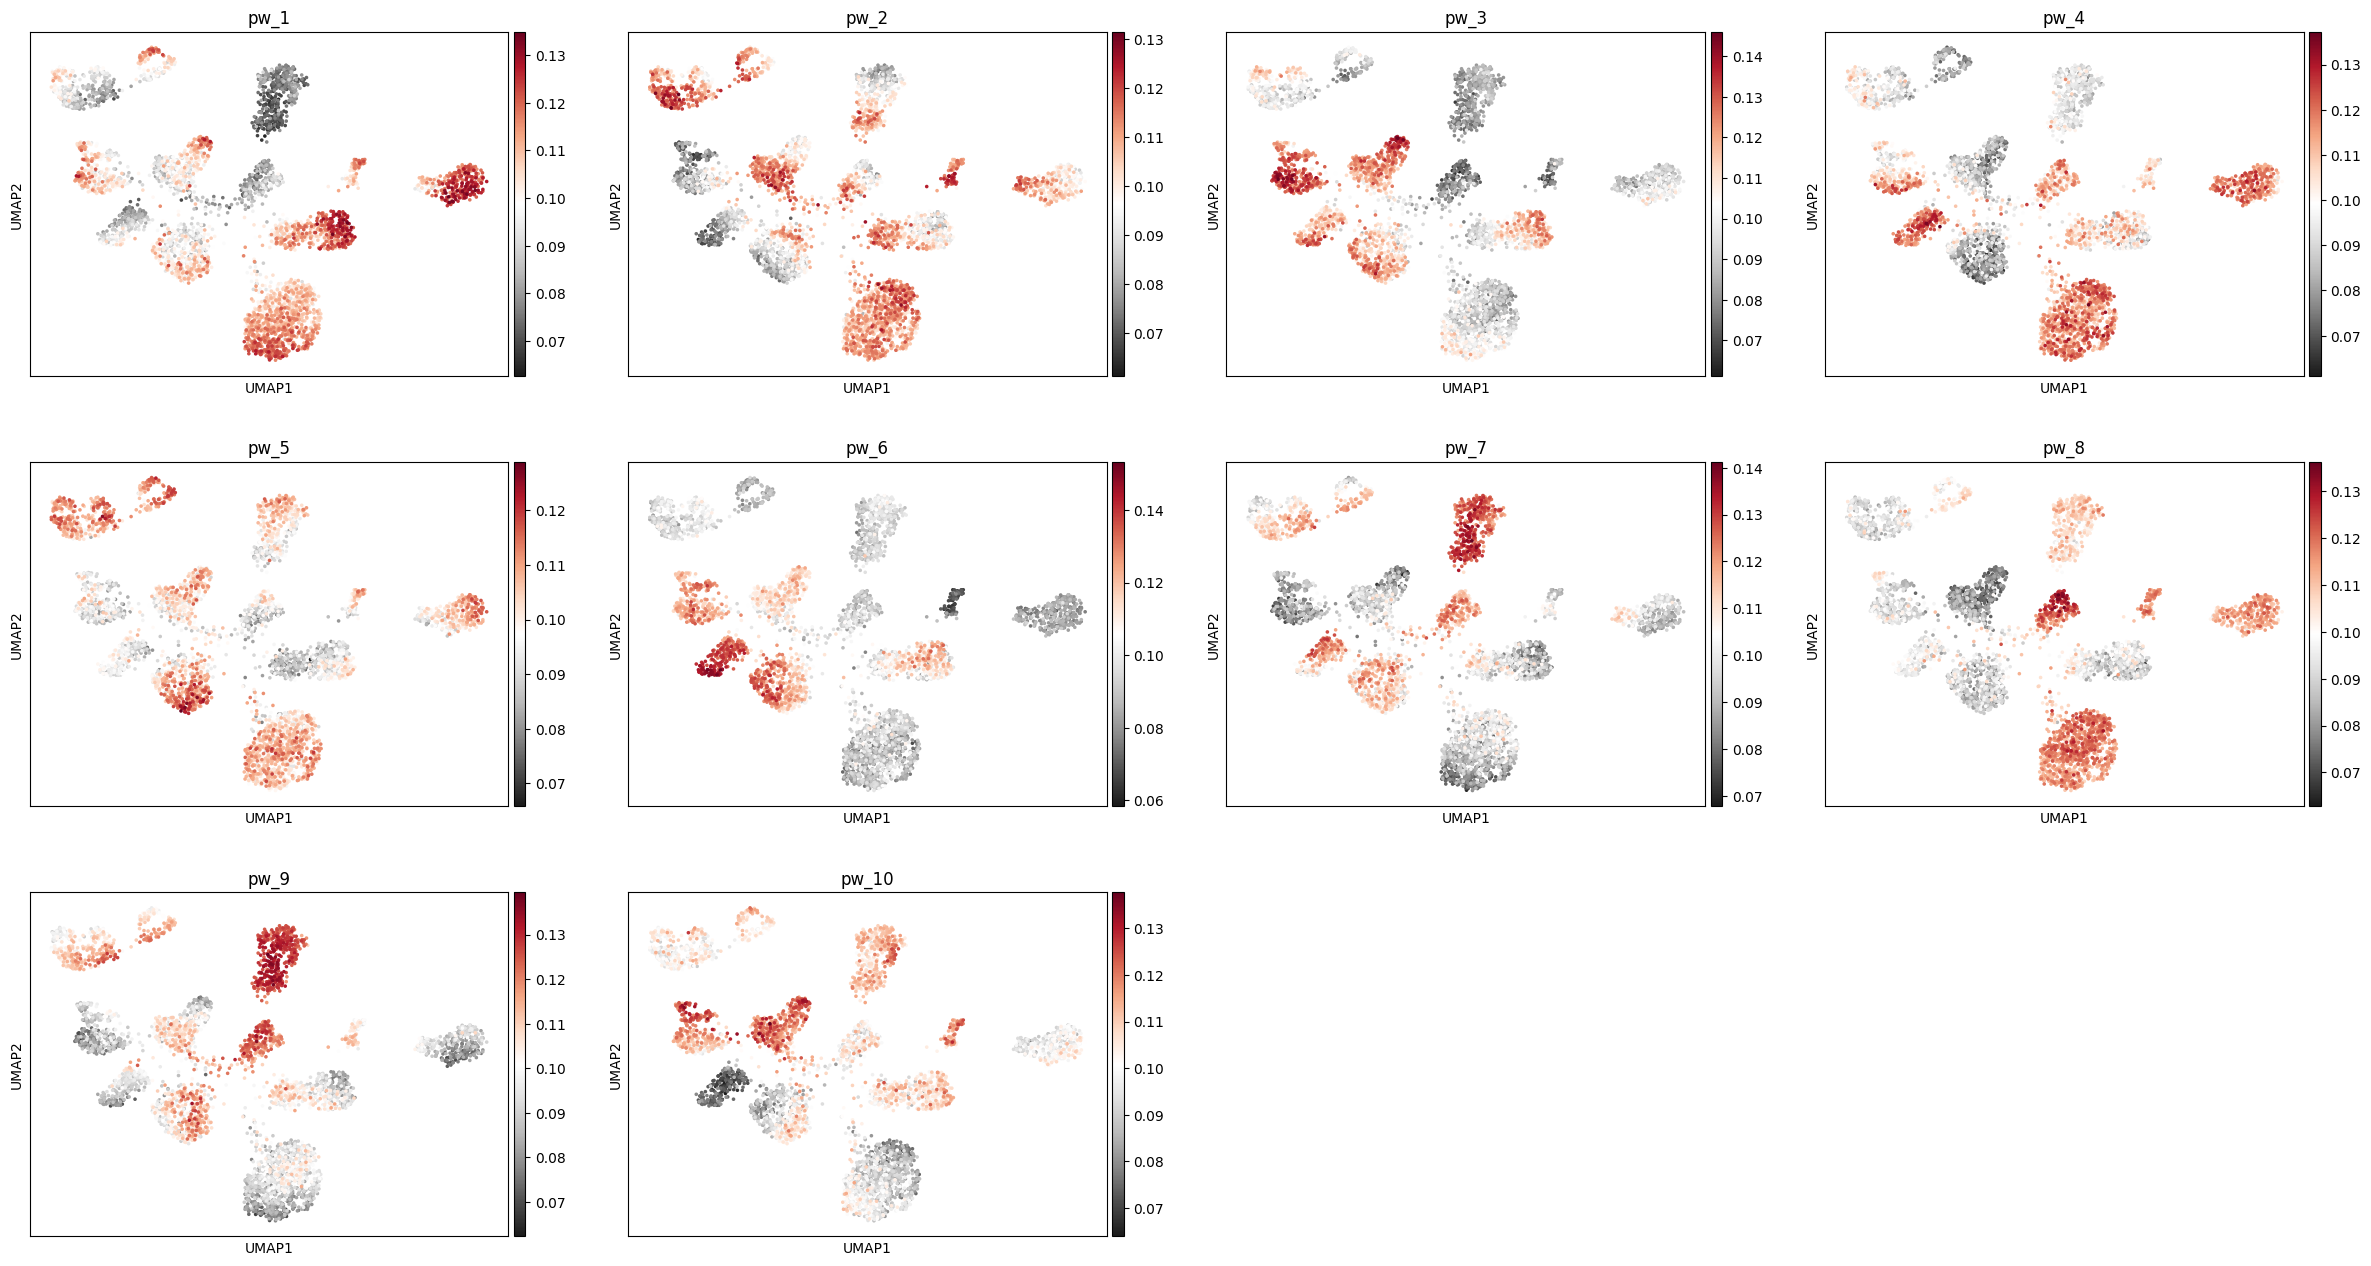

In [14]:
n_dynamics = model.transport_op.n_dynamics
sc.pl.embedding(
    adata_VAPOR,
    color=[f"pw_{i+1}" for i in range(n_dynamics)],
    basis="umap",
    cmap='RdGy_r',
)

computing velocity graph (using 1/8 cores)


    finished (0:00:01) --> added 
    'v_psi1_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi1_umap', embedded velocity vectors (adata.obsm)


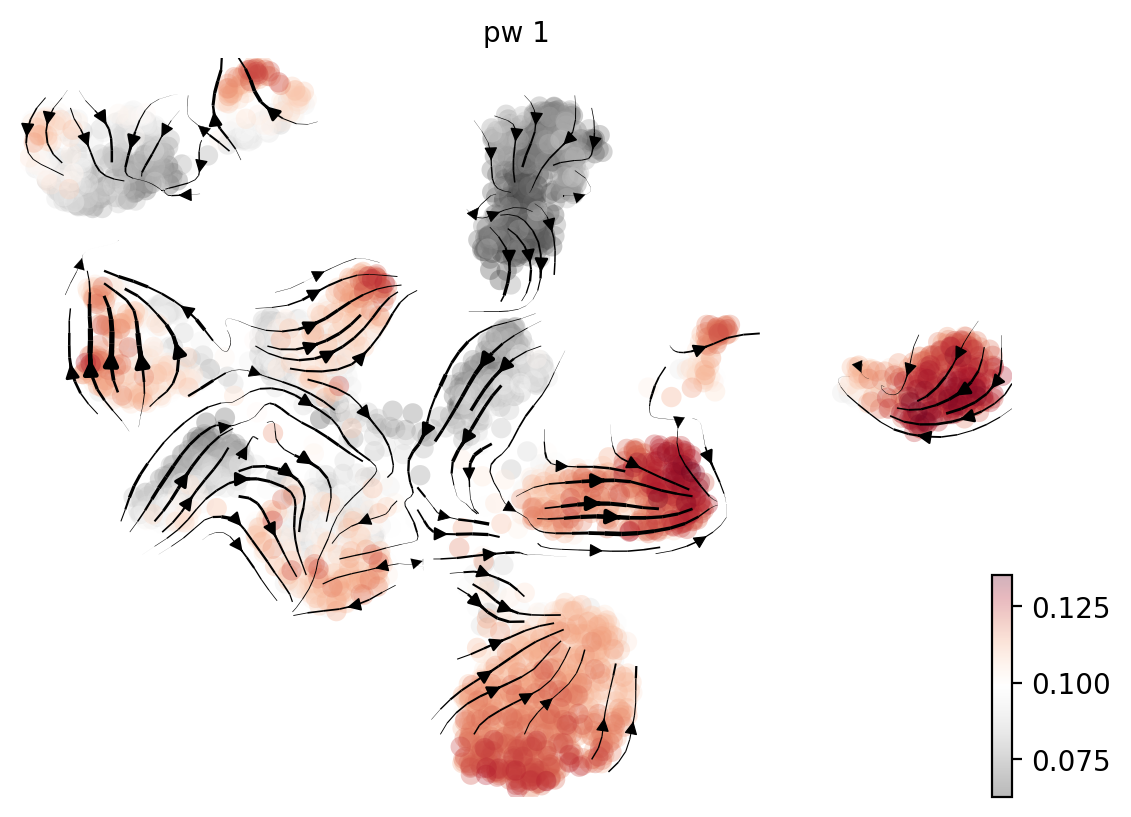

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi2_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi2_umap', embedded velocity vectors (adata.obsm)


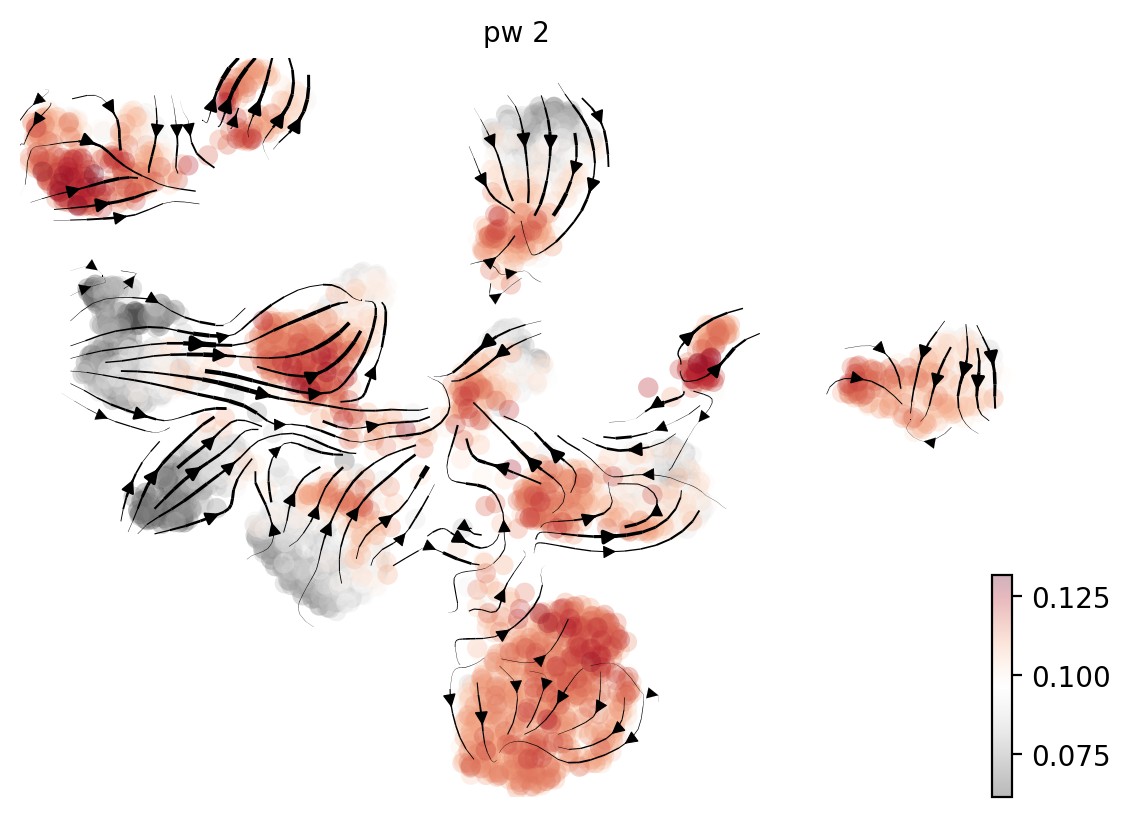

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi3_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi3_umap', embedded velocity vectors (adata.obsm)


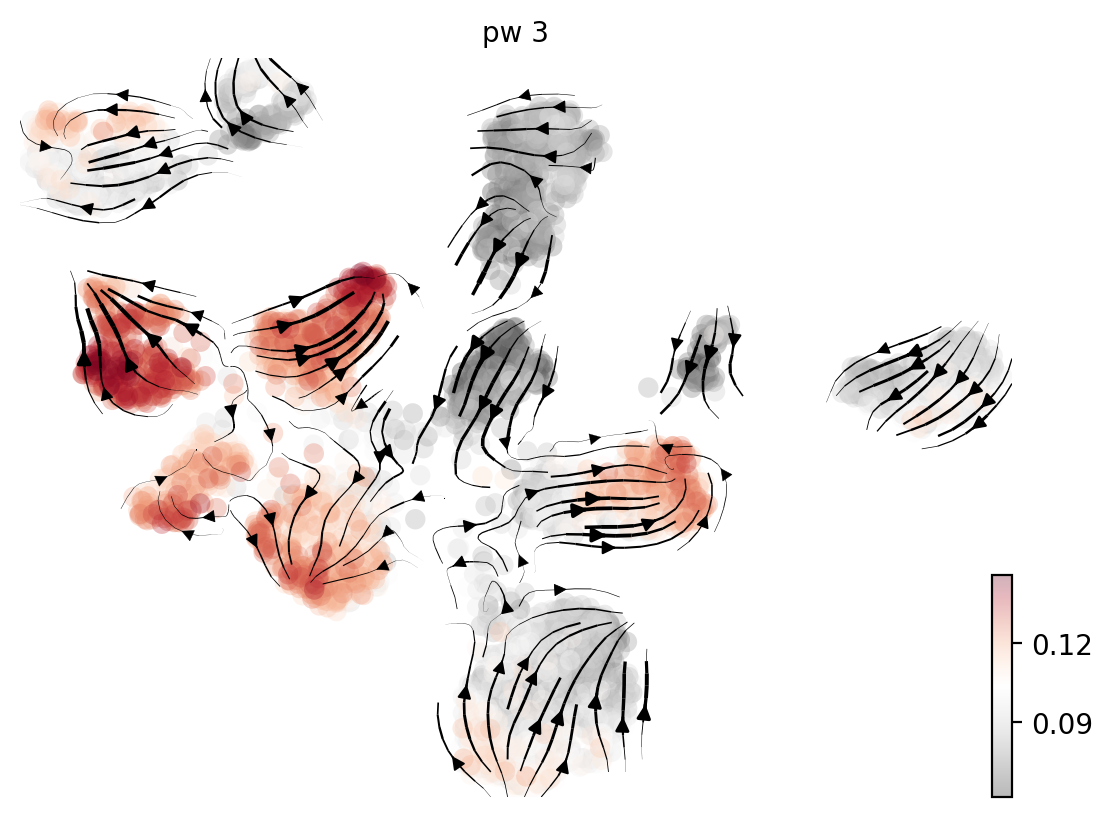

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi4_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi4_umap', embedded velocity vectors (adata.obsm)


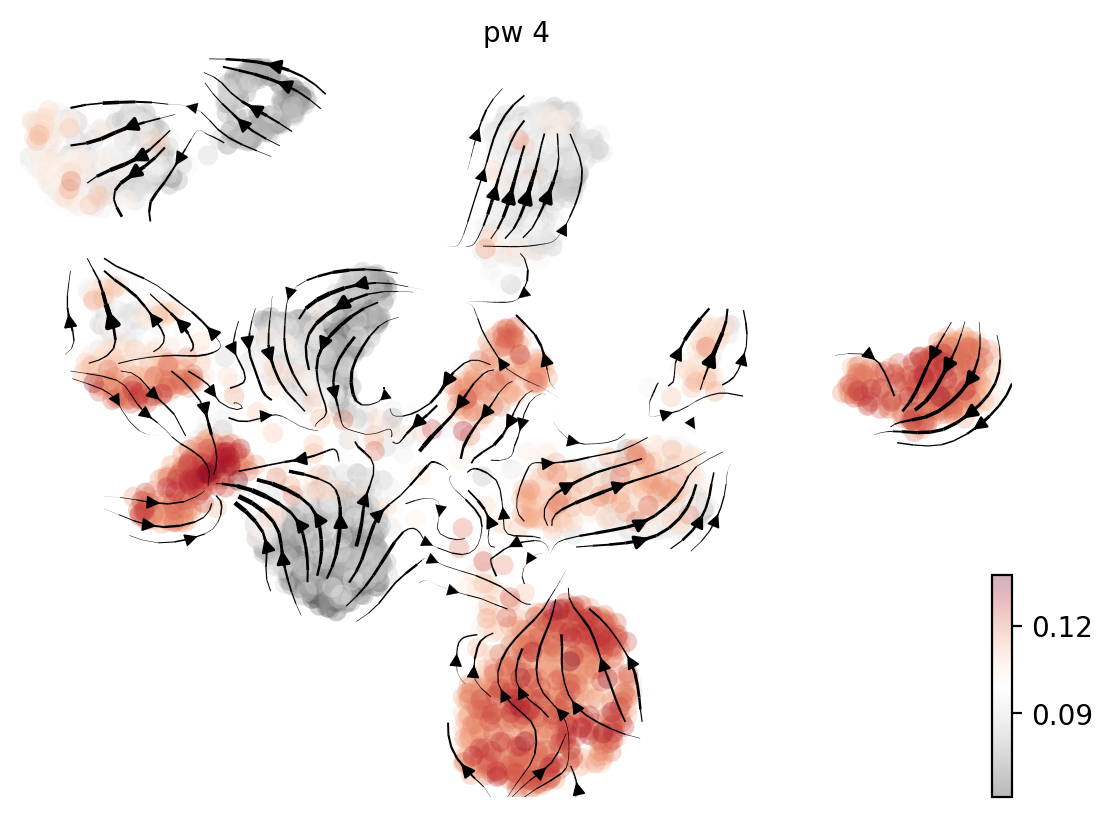

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi5_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi5_umap', embedded velocity vectors (adata.obsm)


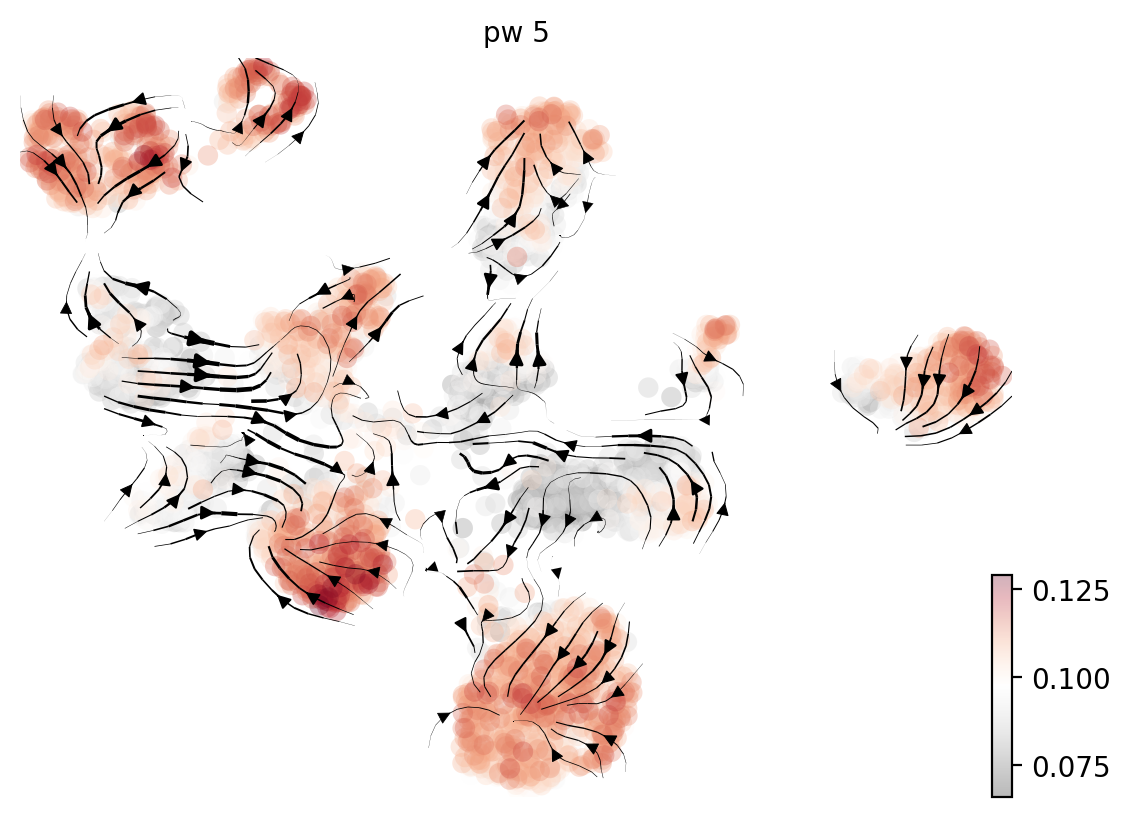

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi6_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi6_umap', embedded velocity vectors (adata.obsm)


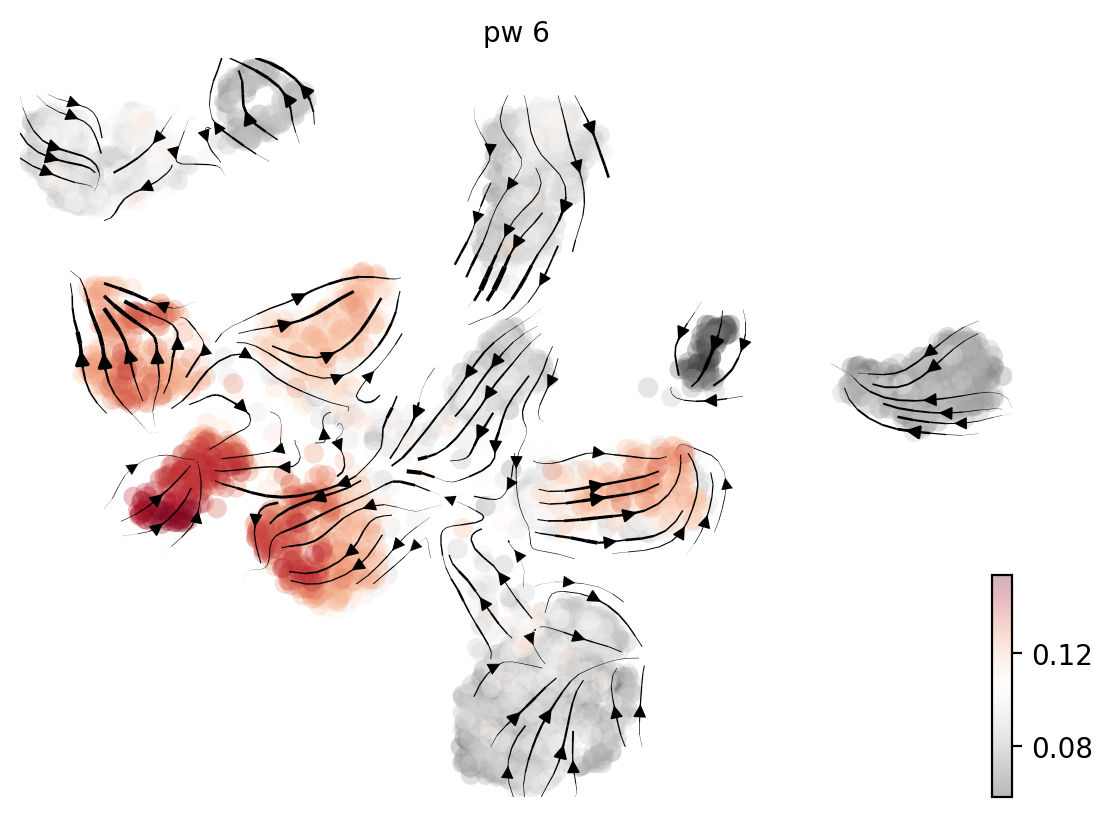

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi7_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi7_umap', embedded velocity vectors (adata.obsm)


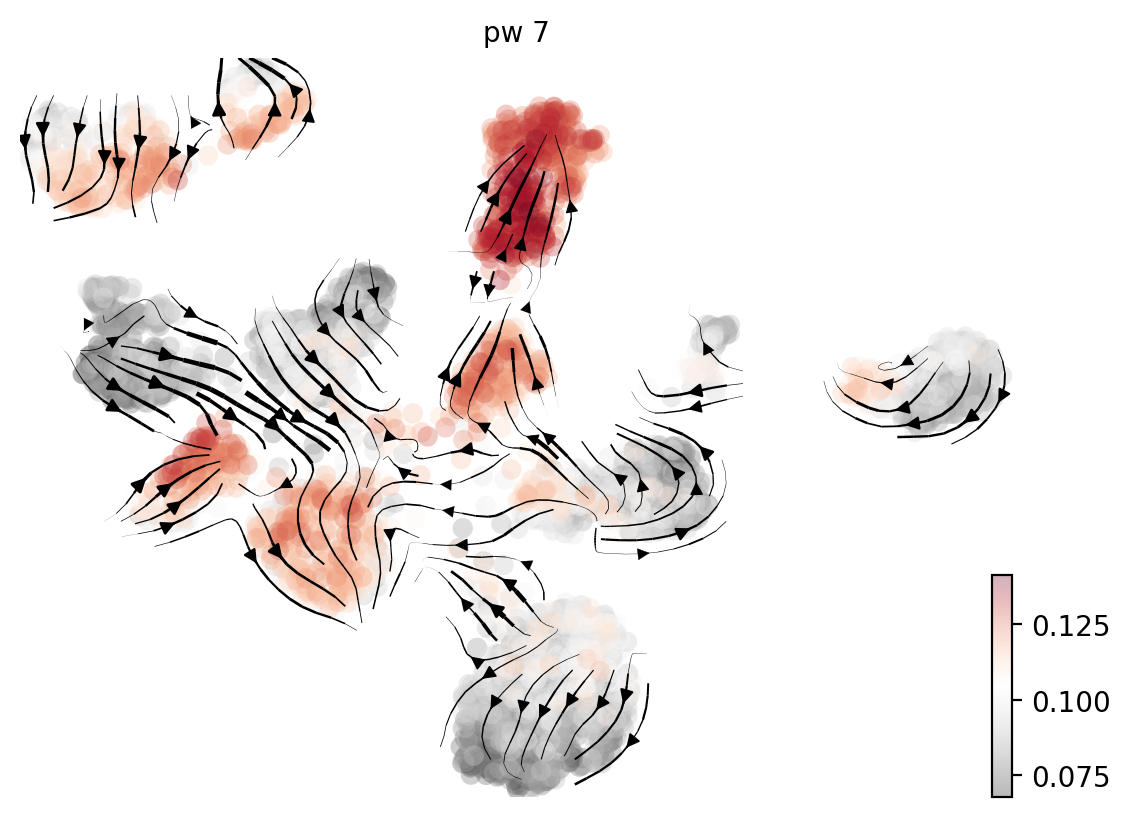

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi8_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi8_umap', embedded velocity vectors (adata.obsm)


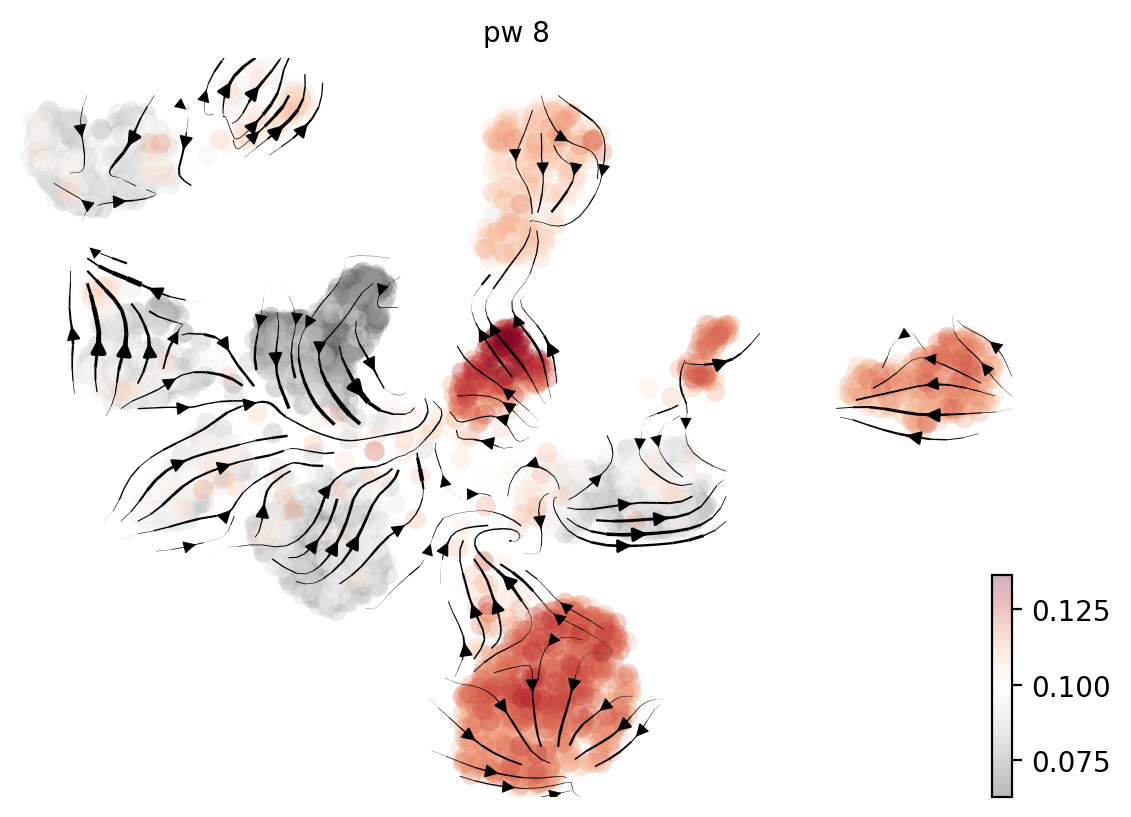

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi9_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi9_umap', embedded velocity vectors (adata.obsm)


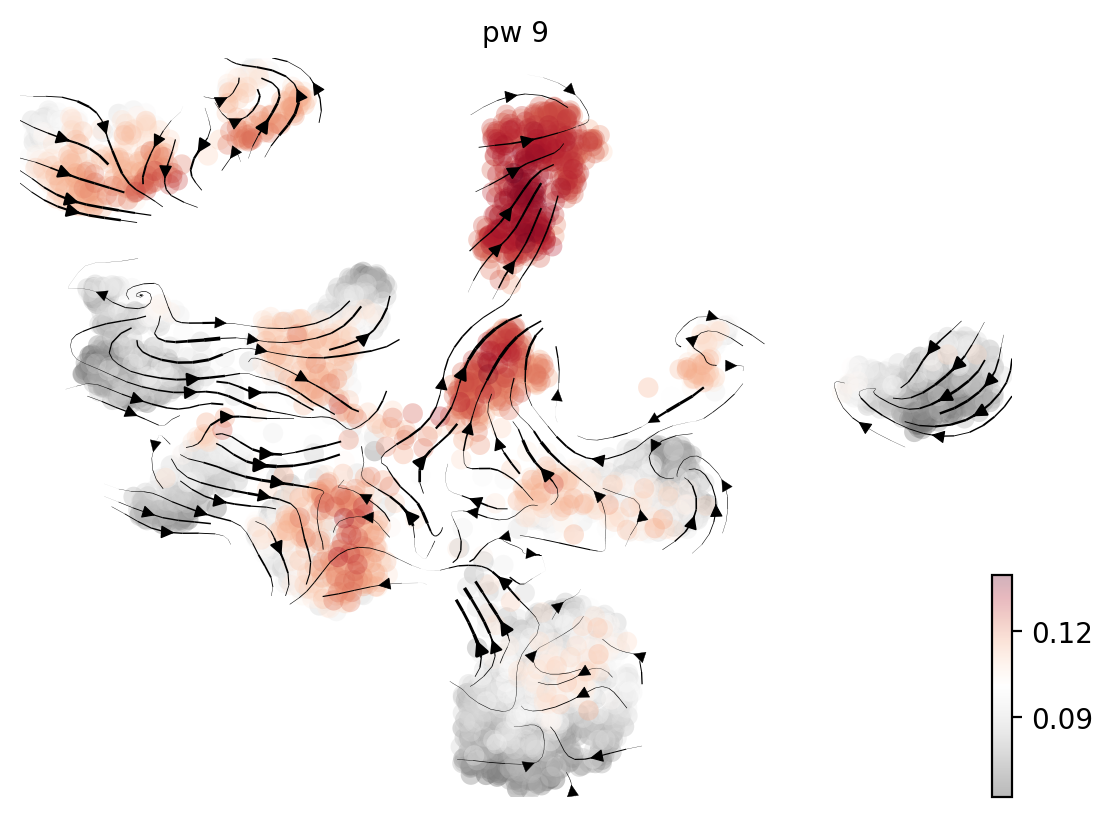

computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi10_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi10_umap', embedded velocity vectors (adata.obsm)


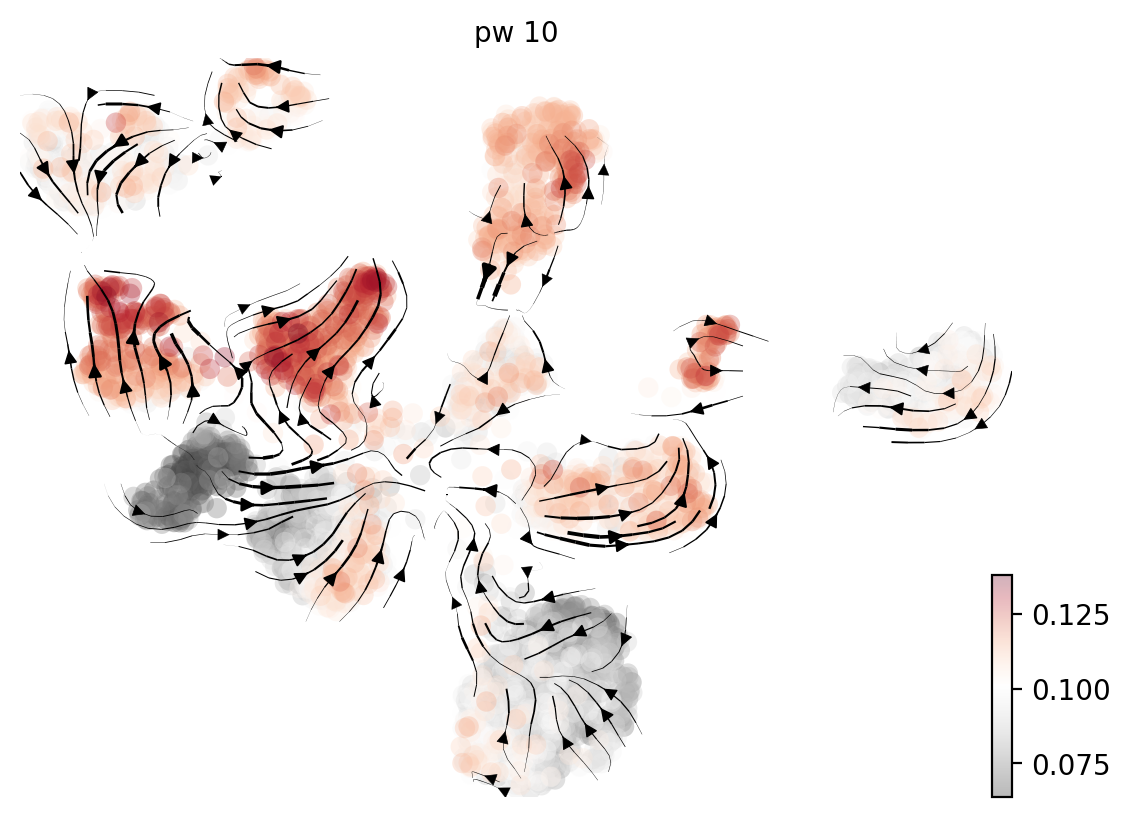

In [15]:
for i in range(n_dynamics):
    sc.pp.neighbors(adata_VAPOR, use_rep='X_VAPOR', random_state=0, n_neighbors=n_neighbors)
    scv.tl.velocity_graph(adata_VAPOR, vkey=f'v_psi{i+1}', xkey='vapor')
    scv.pl.velocity_embedding_stream(
        adata_VAPOR,
        basis='umap',
        vkey=f'v_psi{i+1}',
        color=[f'pw_{i+1}'],
        cmap='RdGy_r',
        show=True,
        n_neighbors=50,
        dpi=200
    )

